In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import datetime as dt
import time
import awkward as ak
import uproot
from tqdm import tqdm
from glob import glob
from scipy import stats as st
from scipy import signal
import numba as nb

import mplhep
mplhep.style.use(mplhep.style.ROOT)
plt.rcParams.update({'font.size': 23,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

import re

In [91]:
import polars as pl
runscsv = sorted(glob(f"./runlists/*_runs.csv"))

dfs = [ pl.read_csv(f) for f in runscsv]
def get_efield(run):
    for df in dfs:

        dfo = df.filter(pl.col('Run')==run)
        if not dfo.is_empty():
            return dfo['Efield'].to_list()[0]
    return -1


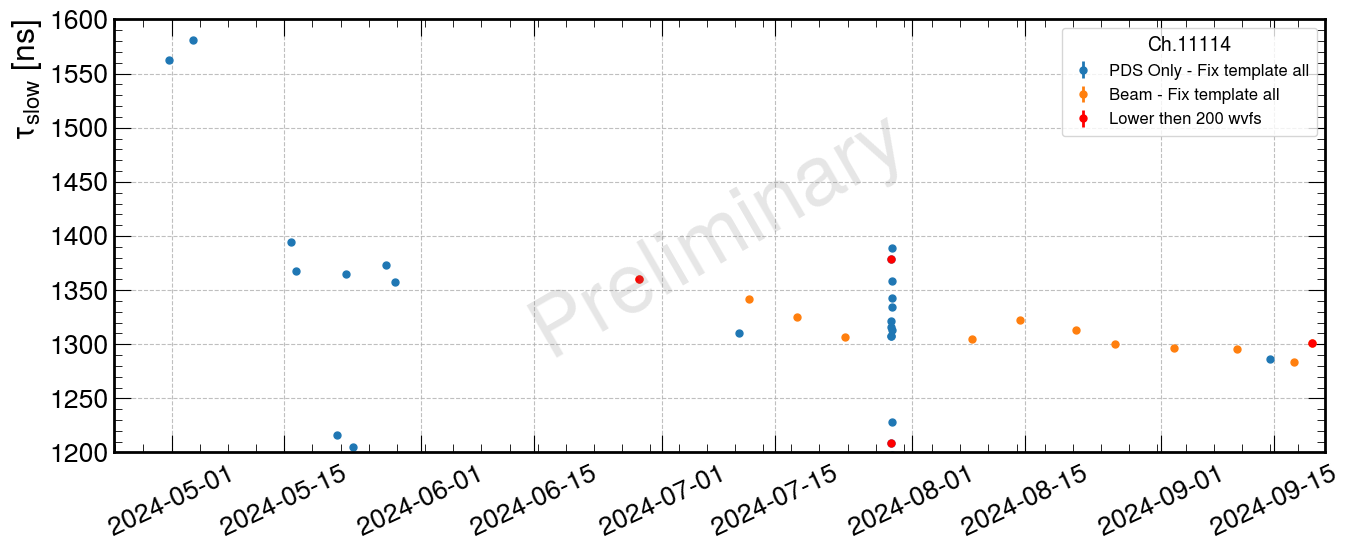

In [145]:
def selection(data):
    _data = data[data['nwvf']<200]
    return _data

def read_conv_data(folder = "./results_fixtemplate", ch = 11225):
    files = sorted(glob(f"{folder}/run0*/convolution_output*.txt"))
    files = [ f for f in files if str(ch) in f]


    dtp = np.dtype([
        ("timestamp", np.uint64),
        ("A_f", np.float32),
        ("tau_f", np.float32 ),
        ("tau_s", np.float32 ),
        ("Efield", np.float32 ),
        ("run", np.int16 ),
        ("time", np.object_ ),
        ("chi2", np.float32 ),
        ("nwvf", np.int64 ),
    ])

    data = np.zeros(len(files), dtype=dtp)
    runs = []
    for i, file in enumerate(files):
        tmp = np.fromfile(file, sep=' ')
        p = re.compile('[0-9]+')
        runnumber = file.strip(f'{folder}/run0')
        runnumber = (int(p.match(runnumber).group(0)))
        runs.append(runnumber)

        data[i]['timestamp'] = tmp[0]*16e-9
        data[i]['A_f'] = tmp[1]
        data[i]['tau_f'] = tmp[2]
        data[i]['tau_s'] = tmp[3]
        data[i]['run'] = runnumber
        data[i]['Efield'] = get_efield(runnumber)
        data[i]['time'] = dt.datetime.fromtimestamp(tmp[0]*16e-9)
        data[i]['chi2'] = tmp[4]
        data[i]['nwvf'] = tmp[5]


    return data

def preliminary(ax, x=0.5, y=0.5):
    ax.text(x, y, 'Preliminary', transform=ax.transAxes,
            fontsize=60, color='gray', alpha=0.2,
            ha='center', va='center', rotation=30)
def plot_vs_time(data,
                 x='time',
                 y='tau_s',
                 skipp = None,
                 endp = None,
                 label='',
                 showHours=False,
                 loc='best',
                 xlim = None,
                 selection=None,
                 legfontsize=16,
                 legtitle='',
                 **kwargs):
        
    if selection:
        data = selection(data)
    if 'linewidth' not in kwargs.keys():
        kwargs['linewidth'] = 2
    if 'markersize' not in kwargs.keys():
        kwargs['markersize'] = 10
    if 'yerr' not in kwargs.keys():
        kwargs['yerr'] = 0
    if 'fmt' not in kwargs.keys():
        kwargs['fmt'] = '.'
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    if showHours:
        xfmt = mdate.DateFormatter('%Y-%m-%d\n%H:%M')
    else:
        xfmt = mdate.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    plt.errorbar(data[x][skipp:endp], data[y][skipp:endp], label=label, **kwargs)
    plt.ylabel(r'$\tau_{slow}$ [ns]')
    plt.legend(title=legtitle,loc=loc,frameon=True, fontsize=legfontsize, title_fontsize=legfontsize+2)
    plt.xlim(xlim)
    
# data = read_conv_data("./results_fixtemplate/")
ch = 11114
data = read_conv_data("./results/", ch=ch)
datafix = read_conv_data("./results_fixtemplate/", ch=ch)
datafix2 = read_conv_data("./results_new_template_fixtemplate/", ch=ch)
datafixu = read_conv_data("./results_ultimate_fixtemplate/", ch=ch)
databeam = read_conv_data("./results_beam/", ch=ch)
databeamfix = read_conv_data("./results_beam_fixtemplate/", ch=ch)
databeamfix2 = read_conv_data("./results_beam_new_template_fixtemplate/", ch=ch)
databeamfixu = read_conv_data("./results_beam_ultimate_fixtemplate/", ch=ch)

xlim=(None,None)
# xlim = (dt.datetime(2024,7,29,10), dt.datetime(2024,7,29,12))
varplot = dict(
    x = 'time',
    y = 'tau_s',
    skipp=None,
    endp=None,
    showHours = False,
    legtitle=f"Ch.{ch}",
    legfontsize=12,
)
varplot_low_nwvf = varplot.copy()
varplot_low_nwvf.update(dict(
    selection=selection,
    color='r'
))
# plot_vs_time(data, label='PDS Only - Dynamic template', **varplot)
# plot_vs_time(datafix, label='PDS Only - Fix template 26261', **varplot)
# plot_vs_time(datafix2, label='PDS Only - Fix template 29177', **varplot)
plot_vs_time(datafixu, label='PDS Only - Fix template all', **varplot)
# plot_vs_time(databeam, label='Beam - Dynamic template', **varplot)
plot_vs_time(databeamfixu, label='Beam - Fix template all',**varplot)
# plot_vs_time(databeamfix, label='Beam - Fix template 26261', **varplot)
# plot_vs_time(databeamfix2, label='Beam - Fix template 29177', **varplot)
plot_vs_time(datafixu, label='Lower then 200 wvfs', **varplot_low_nwvf)
plot_vs_time(databeamfixu, label='', **varplot_low_nwvf)
preliminary(plt.gca())
plt.xlim(xlim)
# plt.yscale('log')
# plt.ylabel('N waveforms in average')
plt.ylim(1200,1600)
plt.savefig(f'tau_vs_time_ch{ch}.png', dpi=200)

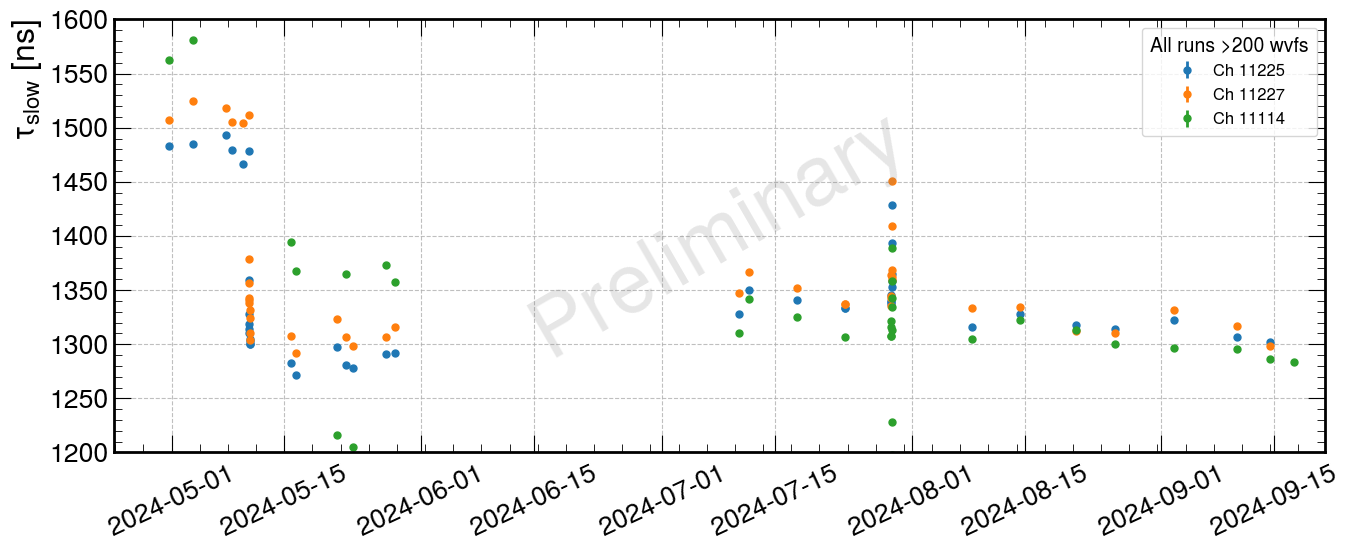

In [146]:
merged = {}
ch = 11225
datafixu = read_conv_data("./results_ultimate_fixtemplate/", ch=ch)
databeamfixu = read_conv_data("./results_beam_ultimate_fixtemplate/", ch=ch)
merged[ch] = np.append(datafixu, databeamfixu)
ch = 11227
datafixu = read_conv_data("./results_ultimate_fixtemplate/", ch=ch)
databeamfixu = read_conv_data("./results_beam_ultimate_fixtemplate/", ch=ch)
merged[ch] = np.append(datafixu, databeamfixu)
ch = 11114
datafixu = read_conv_data("./results_ultimate_fixtemplate/", ch=ch)
databeamfixu = read_conv_data("./results_beam_ultimate_fixtemplate/", ch=ch)
merged[ch] = np.append(datafixu, databeamfixu)

def selection_bigger(data):
    _data = data[data['nwvf']>200]
    return _data

xlim=(None,None)
varplot = dict(
    x = 'time',
    y = 'tau_s',
    skipp=None,
    endp=None,
    showHours = False,
    legtitle=f"All runs >200 wvfs",
    legfontsize=12,
    selection=selection_bigger,
)
for k in merged.keys():
    plot_vs_time(merged[k], label=f'Ch {k}', **varplot)
preliminary(plt.gca())
plt.xlim(xlim)
plt.ylim(1200,1600)
plt.savefig(f'tau_vs_time_all_channels.png', dpi=200)

In [77]:
import plotly.graph_objects as go
def iplot_vs_time(fig:go.Figure, data=None, x='time', y='tau_s', name='', yaxis_range =[None,None], selection=None):
    
    if selection:
        data = selection(data)
    fig.add_trace(go.Scatter(x=data[x], y=data[y], mode='markers', name=name))


selection = None
fig = go.Figure()
x='run'
y='nwvf'
# iplot_vs_time(fig, x=x, y=y, data=data, name='PDS Only - Dynamic template', selection=selection)
iplot_vs_time(fig, x=x, y=y, data=datafix, name='PDS Only - Fix template 26261', selection=selection)
# iplot_vs_time(fig, x=x, y=y, data=datafix2, name='PDS Only - Fix template 29177', selection=selection)
# iplot_vs_time(fig, x=x, y=y, data=datafixu, name='PDS Only - Fix template all', selection=selection)
# iplot_vs_time(fig, x=x, y=y, data=databeam, name='Beam - Dynamic template ', selection=selection)
iplot_vs_time(fig, x=x, y=y, data=databeamfix, name='Beam - Fix template 26261', selection=selection)
iplot_vs_time(fig, x=x, y=y, data=databeamfix2, name='Beam - Fix template 29177', selection=selection)
# iplot_vs_time(fig, x=x, y=y, data=databeamfixu, name='Beam - Fix template all', selection=selection)
# fig.update_layout(yaxis_range=[1200,1700])
fig.show()


In [187]:
data[data['nwvf'] > 500]['nwvf']

array([11335, 17038, 17264, 16939, 19265, 19778, 19711, 17057, 20180,
       14888, 12766,  9894,  8971,  8006,  6256,  7944,  8362,  9367,
        9168,  9232,  1690,  1689,   752,   808,   893,   916,   944,
        1024,  1076,  1090,   607])

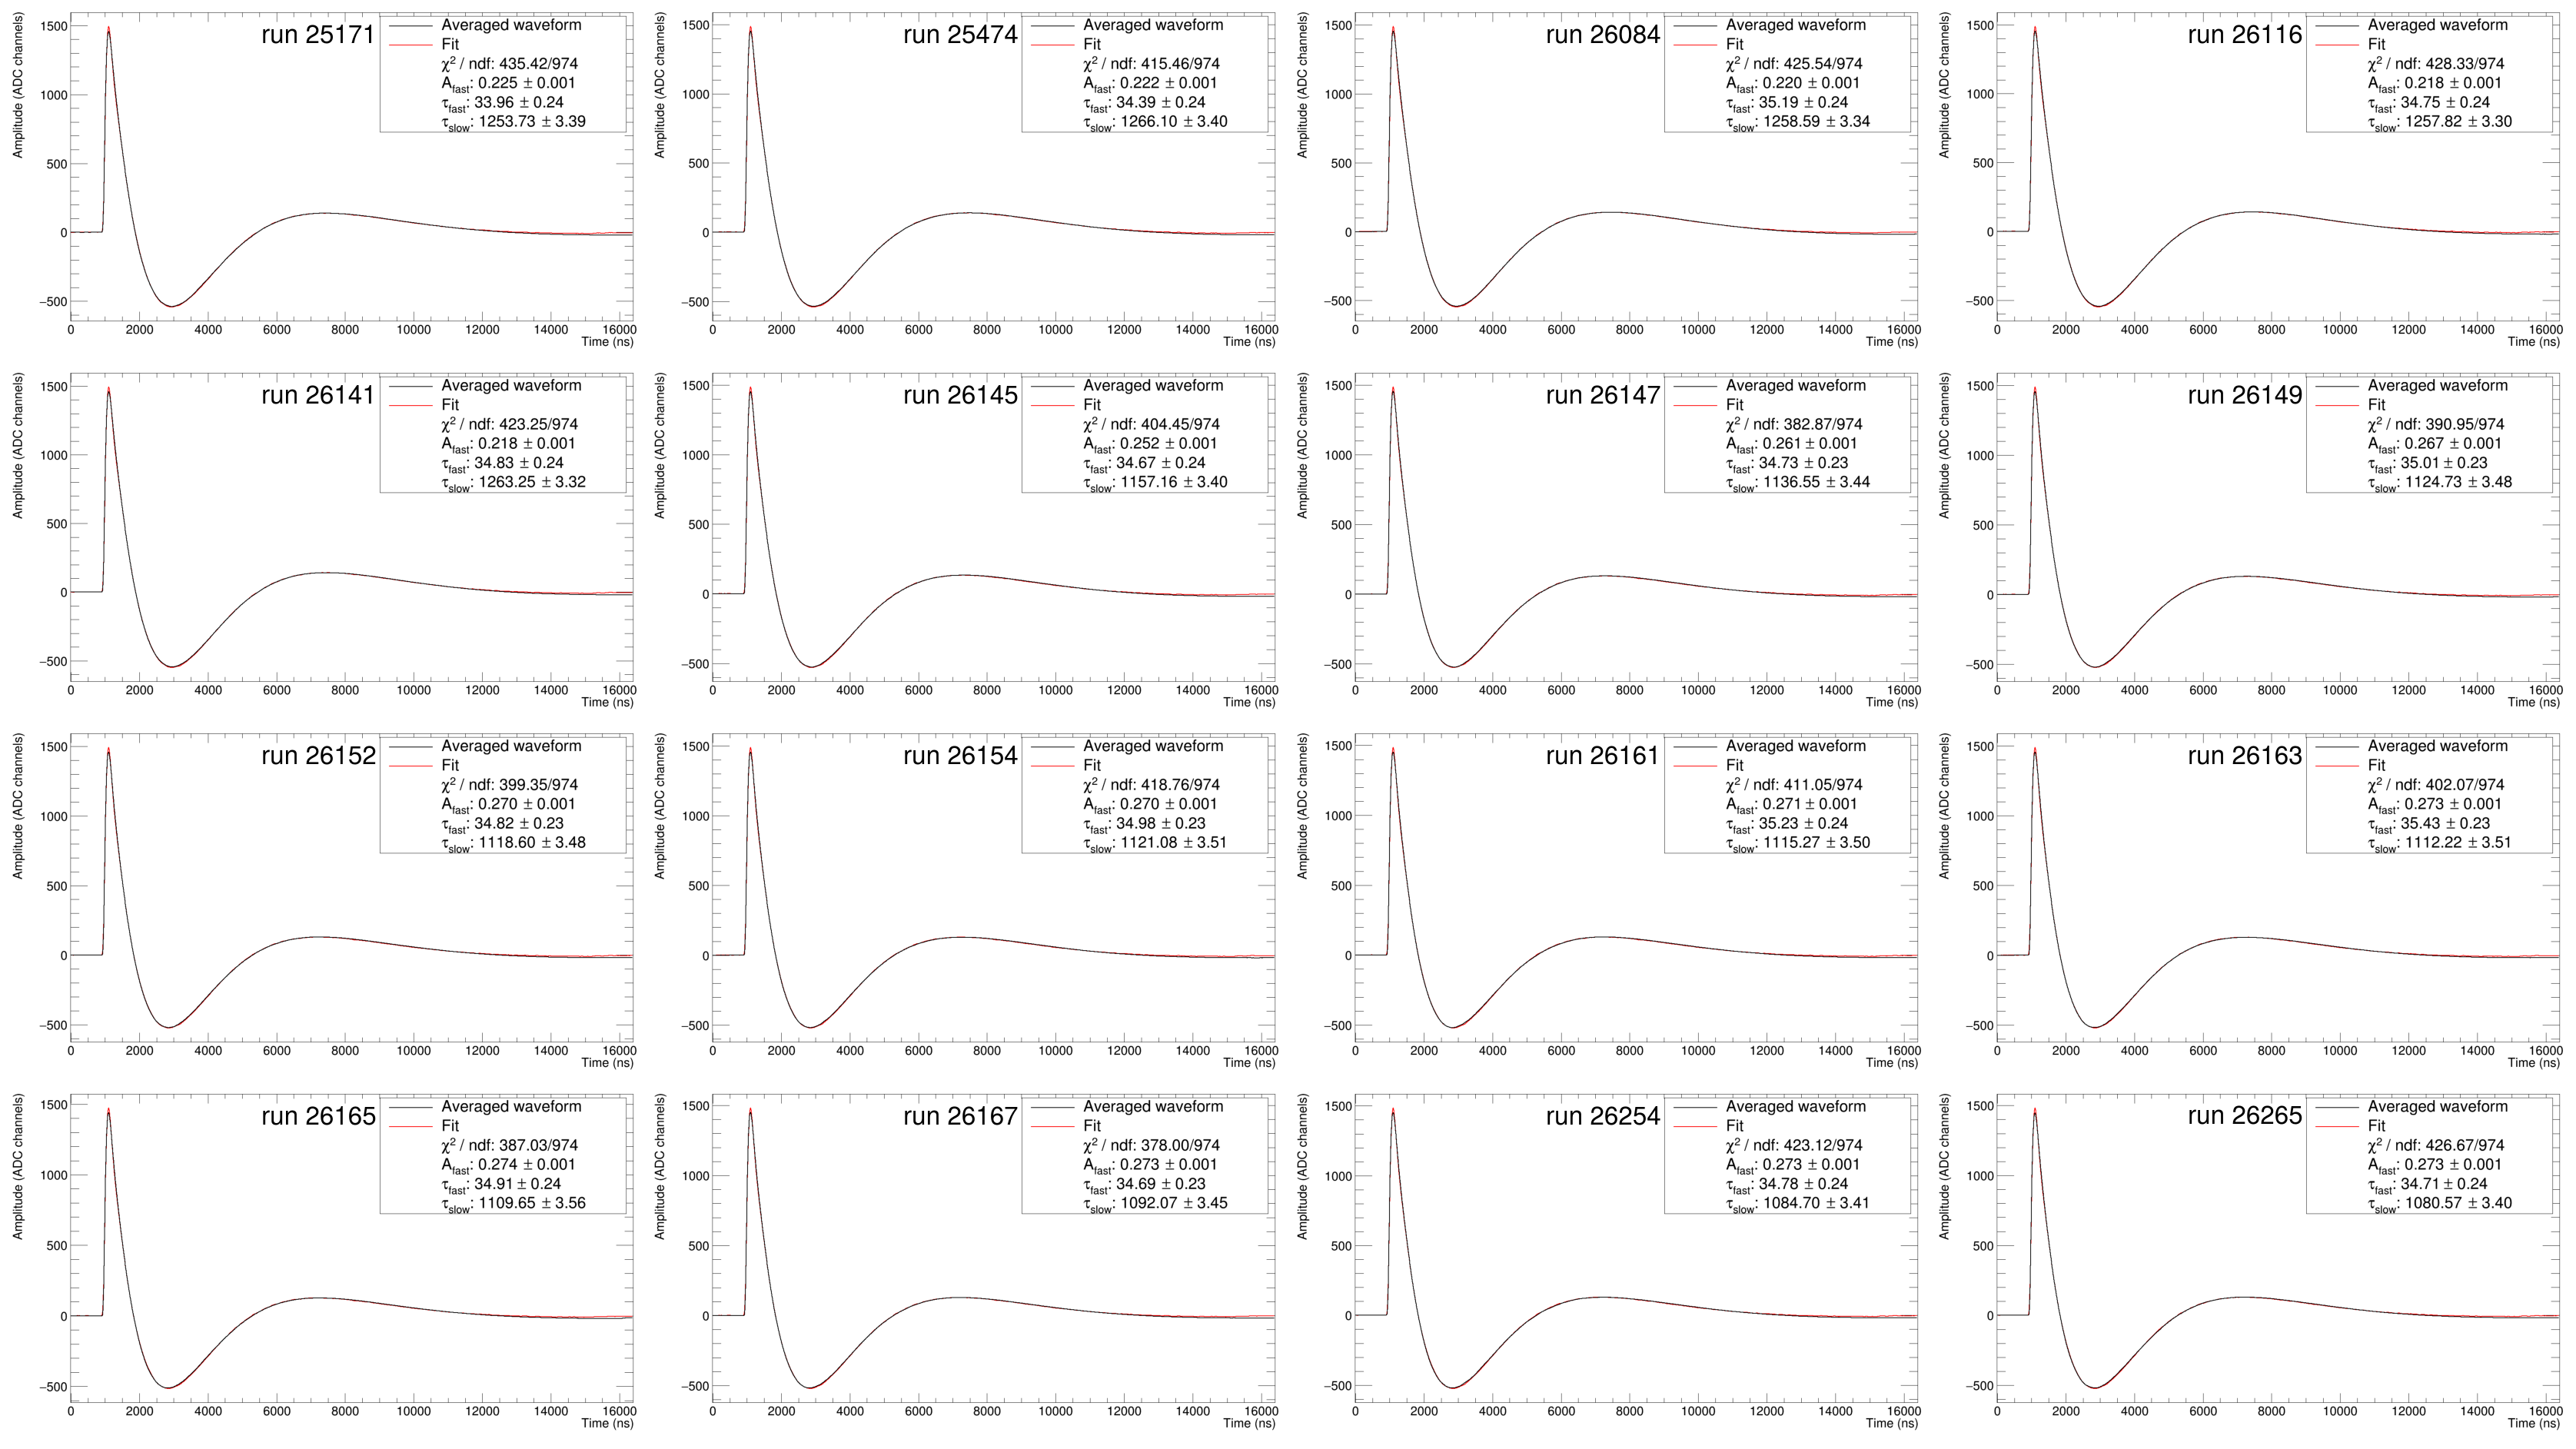

/tmp/ipykernel_3745434/1503176438.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('all_results.pdf', dpi=300, bbox_inches='tight')


In [78]:
from mpl_toolkits.axes_grid1 import ImageGrid
import re

fig = plt.figure(figsize=(34, 34.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
                 axes_pad=0.1,  # pad between Axes in inch.
                 )

for ax, im in zip(grid, files_plot_resuls):
    ax:plt.Axes
    result = plt.imread(im)
    result = result[90:, 20:1750,:]
    p = re.compile('./run0(.+)/conv_')
    m = p.match(im)
    r = f"run {m.group(1)}"
    ax.imshow(result)
    ax.text(0.4,0.9,r, transform=ax.transAxes, fontsize=24)
    ax.axis('off')

plt.show()
fig.savefig('all_results.pdf', dpi=300, bbox_inches='tight')
